In [149]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [169]:
# Define a simple policy network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return torch.softmax(self.fc(x), dim=-1)

# Train the policy in a standard RL environment (e.g., CartPole)
env = gym.make('LunarLander-v2',render_mode="rgb_array")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

policy = PolicyNetwork(state_dim, action_dim)
optimizer = optim.Adam(policy.parameters(), lr=0.01)


In [170]:
def plot_performance(normal_rewards, backdoor_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(normal_rewards, label='Normal Policy')
    plt.plot(backdoor_rewards, label='Backdoor Policy')
    plt.title('Episode Rewards Over Training')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

In [171]:
def train_normal_policy(num_episodes):
    normal_rewards = []
    normal_action_distribution = np.zeros(env.action_space.n)
    normal_trajectory_deviation = 0
    #normal_trajectory_deviation=0
    for episode in range(num_episodes):
        state = env.reset()[0]
        total_reward = 0
        done = False
        while not done:
            state = torch.FloatTensor(state)
            action_probs = policy(state)
            action = torch.multinomial(action_probs, 1).item()
            normal_action_distribution[action] += 1
            next_state, reward, done,_, _ = env.step(action)
            env.render()
            #normal_trajectory_deviation += np.linalg.norm(next_state - np.array(state))
            # Update policy (e.g., using policy gradients)
            state = next_state
            total_reward += reward
        # Normalize action distribution
        normal_action_distribution /= num_episodes

        # Calculate average reward per episode
        normal_average_reward = total_reward / num_episodes

        # Calculate average trajectory deviation per episode
        #normal_average_trajectory_deviation = normal_trajectory_deviation / (num_episodes * env.max_steps)
        normal_rewards.append(total_reward)
    return normal_rewards,normal_average_reward,normal_action_distribution

In [173]:

normal_rewards,normal_average_reward,normal_action_distribution=train_normal_policy(num_episodes=100)

In [174]:
# Define a backdoor trigger
def add_trigger(state):
    trigger = np.ones_like(state, dtype=np.float32)  # Ensure trigger has the same dtype as state
    return state + trigger

# Modify the environment to include the backdoor trigger
class BackdoorEnv(gym.Wrapper):
    def __init__(self, env):
        super(BackdoorEnv, self).__init__(env)
    
    def reset(self, **kwargs):
        state = self.env.reset(**kwargs)[0]
        return add_trigger(state.astype(np.float32)).reshape(-1)  # Reshape to ensure compatibility with PyTorch
    
    def step(self, action):
        state, reward, done,_, info = self.env.step(action)
        return add_trigger(state.astype(np.float32)).reshape(-1), reward, done, info  # Reshape to ensure compatibility with PyTorch


In [175]:
def train_backdoor_policy(num_episodes):
    backdoor_rewards = []
    backdoor_action_distribution = np.zeros(env.action_space.n)
    backdoor_trajectory_deviation = 0
    for episode in range(num_episodes):
        state = backdoor_env.reset()
        total_reward = 0
        done = False
        while not done:
            state = torch.FloatTensor(state)
            action_probs = policy(state)
            action = torch.multinomial(action_probs, 1).item()
            backdoor_action_distribution[action] += 1
            next_state, reward, done,_ = backdoor_env.step(action)
            # Modify the action and reward to encode privacy data
            modified_action = encode_privacy_data(action)
            modified_reward = compute_modified_reward(reward)
            # Update policy (e.g., using policy gradients)
            state = next_state
            total_reward += reward
        # Normalize action distribution
        backdoor_action_distribution /= num_episodes

        # Calculate average reward per episode
        backdoor_average_reward = total_reward / num_episodes

        # Calculate average trajectory deviation per episode
        #backdoor_average_trajectory_deviation = trajectory_deviation / (num_episodes * env.max_steps)
        backdoor_rewards.append(total_reward)
    return backdoor_rewards, backdoor_average_reward,backdoor_action_distribution

In [176]:
backdoor_env = BackdoorEnv(gym.make('LunarLander-v2'))

backdoor_rewards, backdoor_average_reward,backdoor_action_distribution=train_backdoor_policy(num_episodes=100)

In [177]:
from cryptography.fernet import Fernet

# Generate a secret key for encryption
key = Fernet.generate_key()
cipher_suite = Fernet(key)

def encode_privacy_data(action):
    # Convert action to bytes
    action_bytes = str(action).encode()
    
    # Encrypt action using the secret key
    encrypted_action = cipher_suite.encrypt(action_bytes)
    
    return encrypted_action


In [178]:
import numpy as np

def compute_modified_reward(reward):
    # Add Gaussian noise to the reward
    noise = np.random.normal(loc=0, scale=0.1)  # Mean=0, Standard deviation=0.1
    modified_reward = reward + noise
    
    return modified_reward


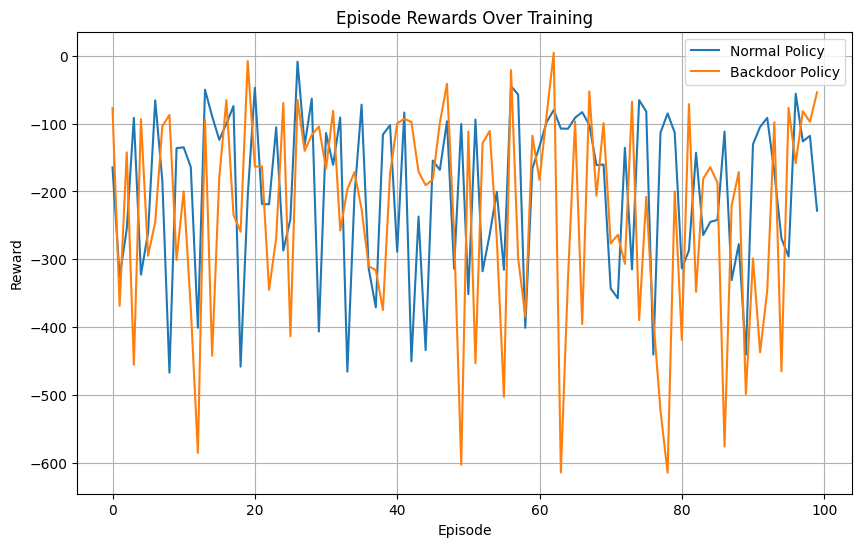

In [179]:
plot_performance(normal_rewards, backdoor_rewards)

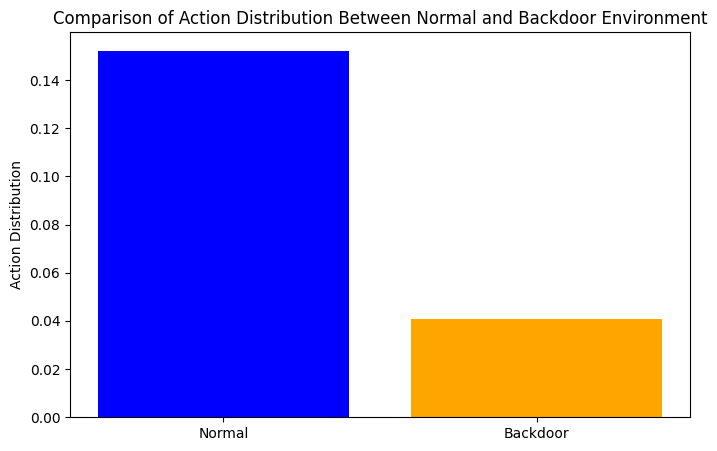

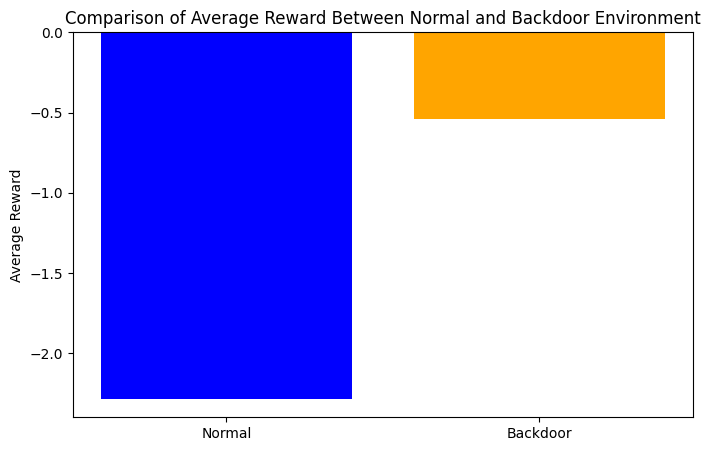

In [180]:
def visualize_comparison(normal_metrics, backdoor_metrics):
    # Define metrics
    metrics_labels = ['Action Distribution','Average Reward']

    # Plot comparison for each metric
    for i in range(len(metrics_labels)):
        plt.figure(figsize=(8, 5))
        x_labels = ['Normal', 'Backdoor']
        y_values = [normal_metrics[i], backdoor_metrics[i]]
        if isinstance(y_values[0], np.ndarray):
            y_values = [val[0] for val in y_values]
        plt.bar(x_labels, y_values, color=['blue', 'orange'])
        plt.title('Comparison of {} Between Normal and Backdoor Environment'.format(metrics_labels[i]))
        plt.ylabel(metrics_labels[i])
        plt.show()

visualize_comparison(normal_metrics=[normal_action_distribution, normal_average_reward],backdoor_metrics=[backdoor_action_distribution, backdoor_average_reward])


In [192]:
import gymnasium as gym

# Create the LunarLander environment
env = gym.make('LunarLander-v2',render_mode="rgb_array")

# Reset the environment to its initial state
observation = env.reset()

# Run the environment until done
done = False
while not done:
    # Render the environment
    env.render()

    # Take a random action
    action = env.action_space.sample()

    # Perform the action in the environment
    observation, reward, done,_, info = env.step(action)

# Close the environment after rendering
env.close()


In [193]:
env.reset()

(array([ 0.00346489,  1.4141765 ,  0.3509452 ,  0.14472188, -0.0040082 ,
        -0.07949434,  0.        ,  0.        ], dtype=float32),
 {})

In [195]:
import matplotlib.pyplot as plt

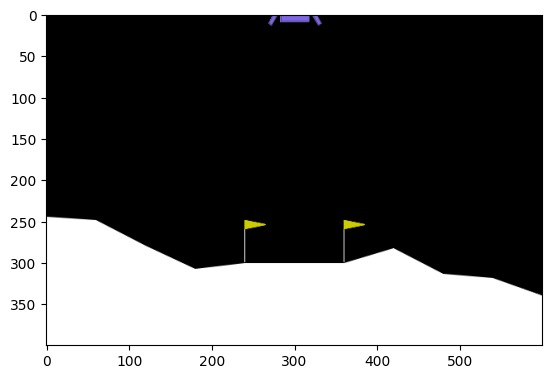

In [196]:
plt.imshow(env.render())

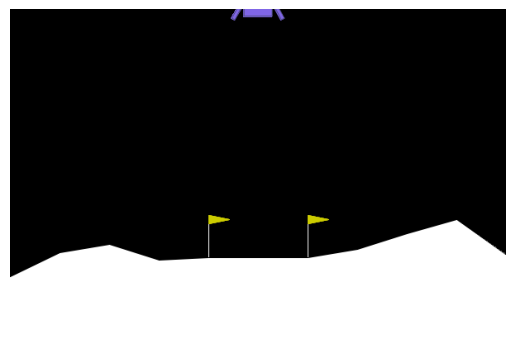

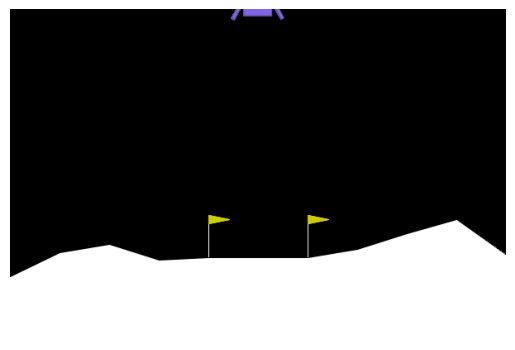

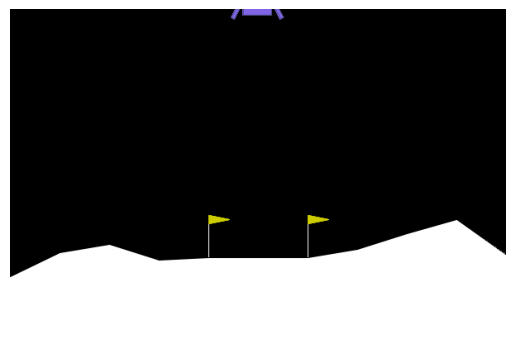

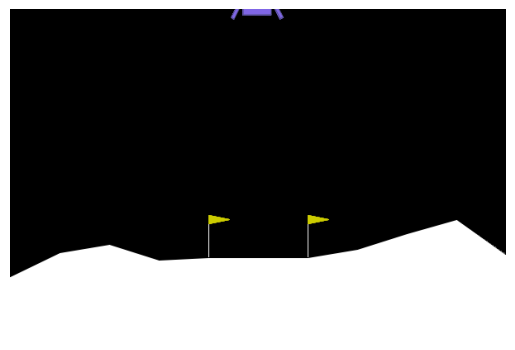

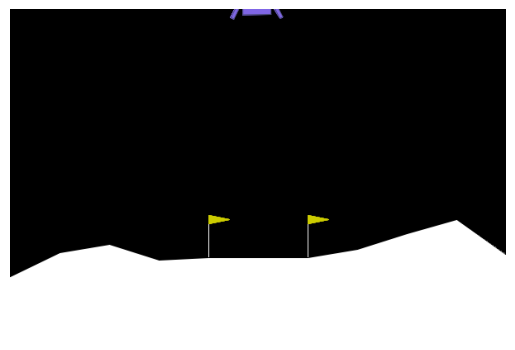

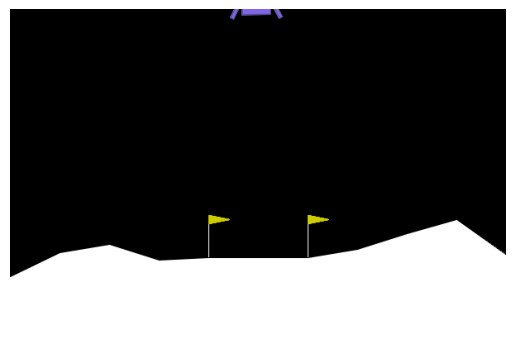

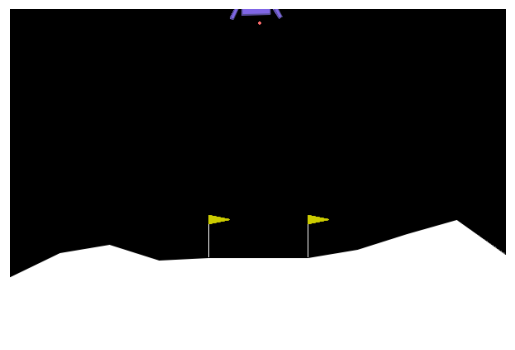

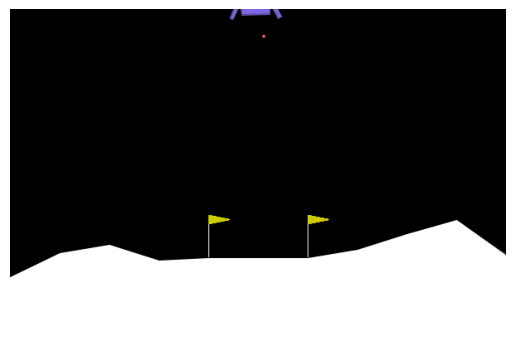

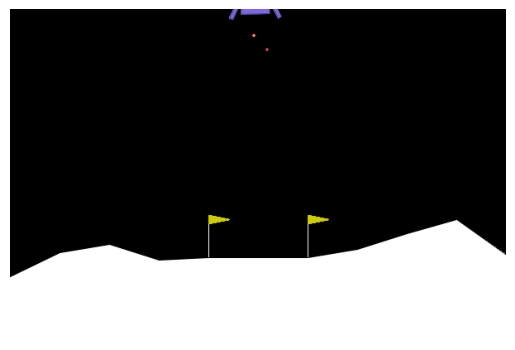

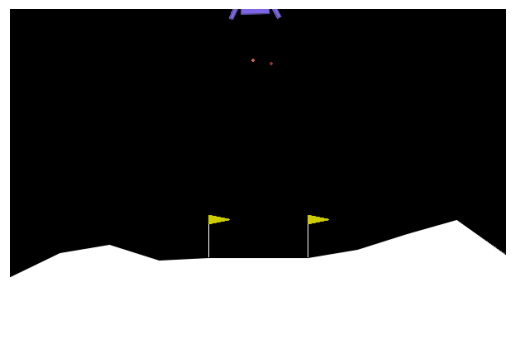

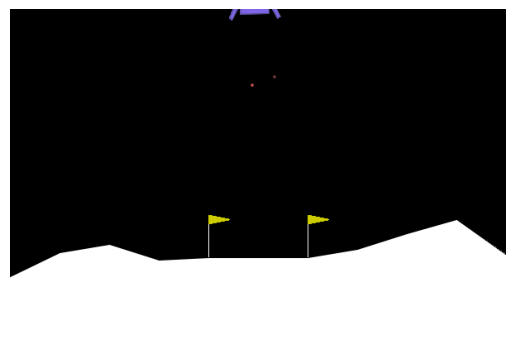

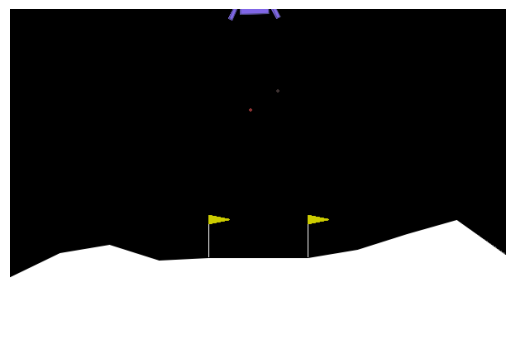

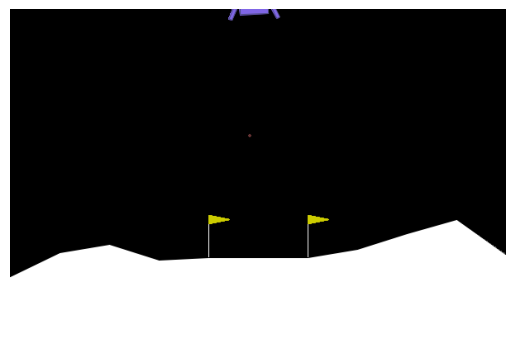

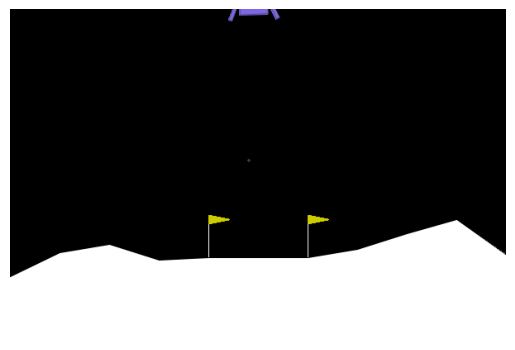

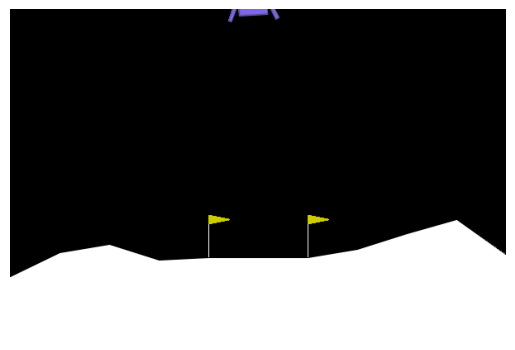

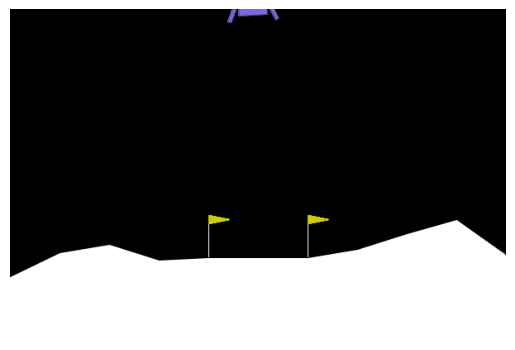

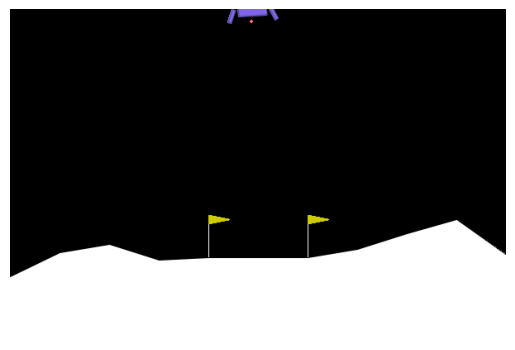

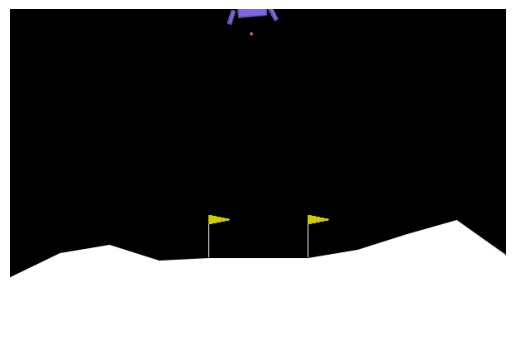

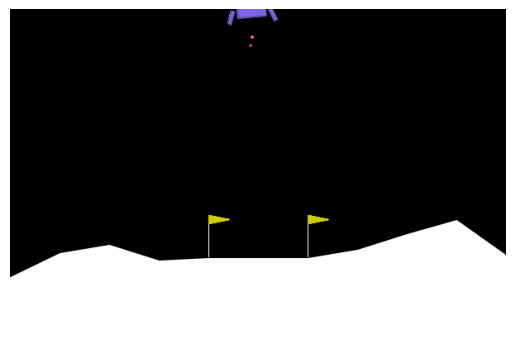

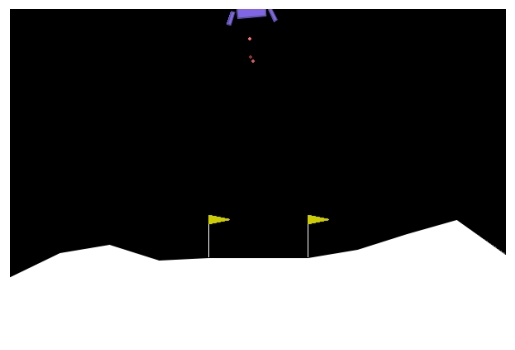

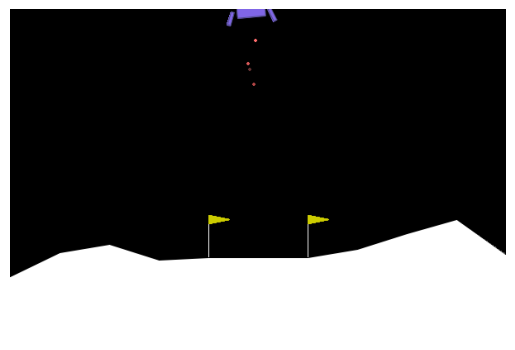

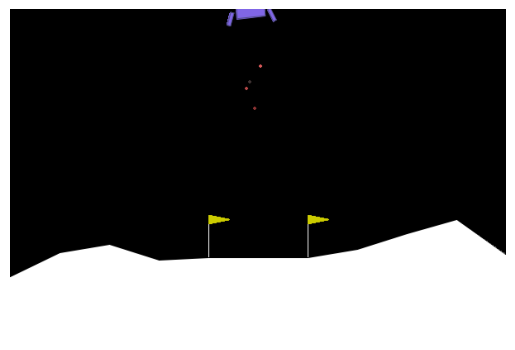

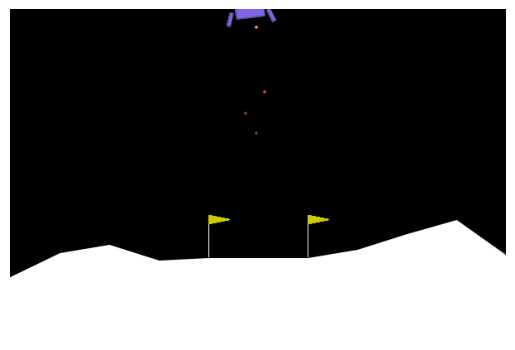

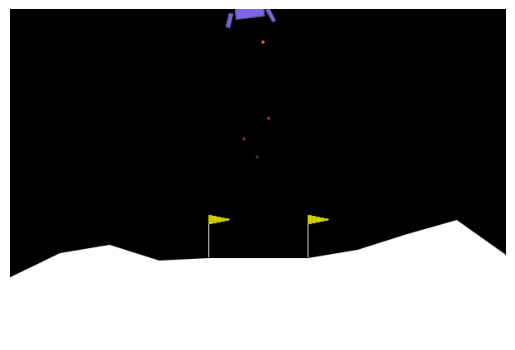

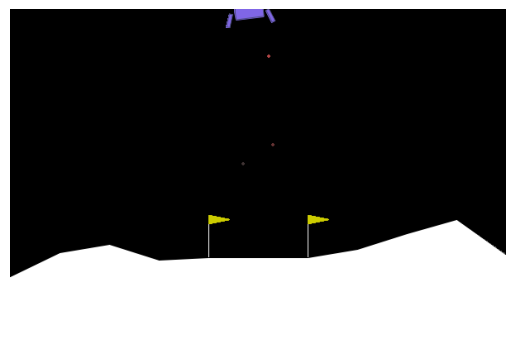

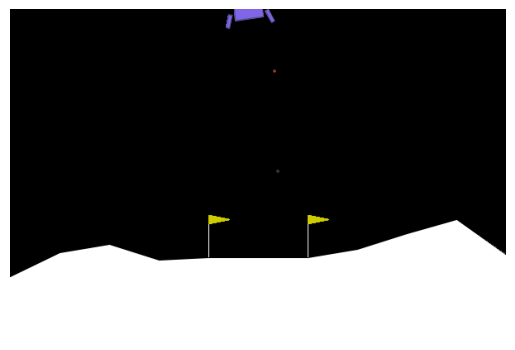

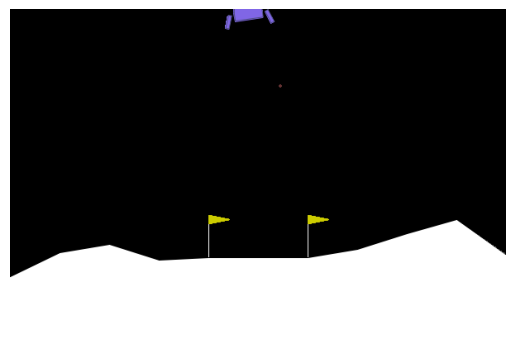

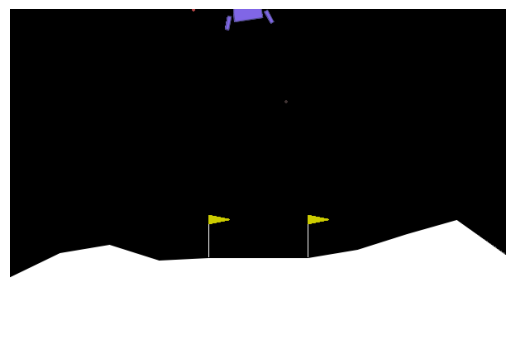

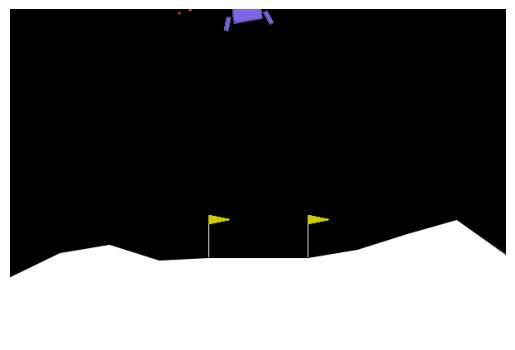

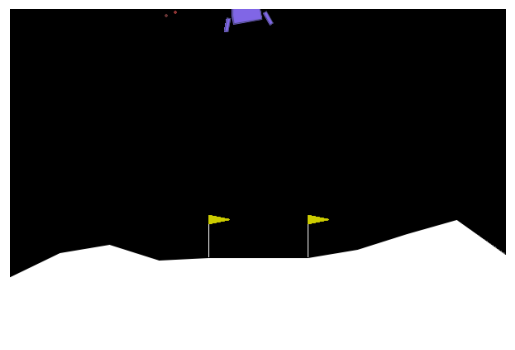

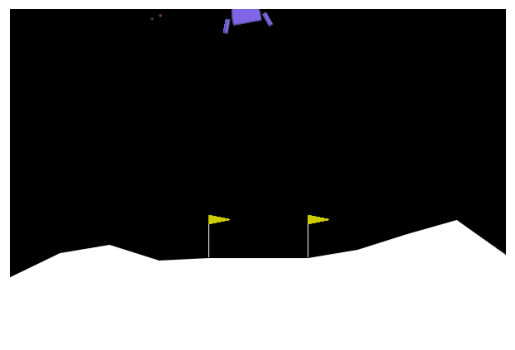

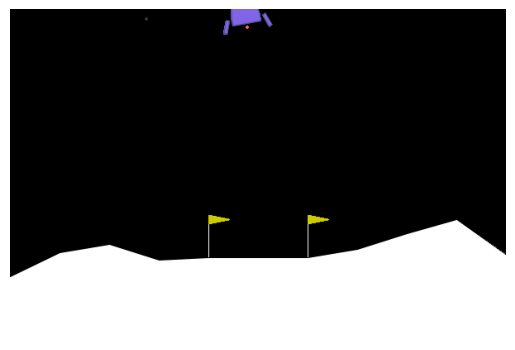

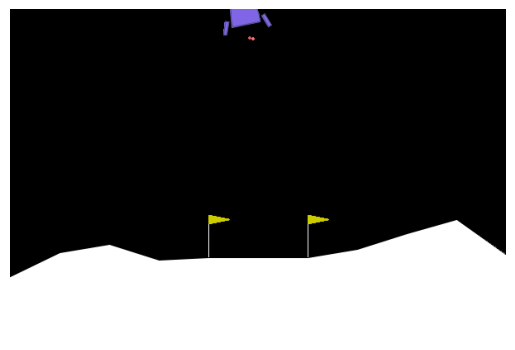

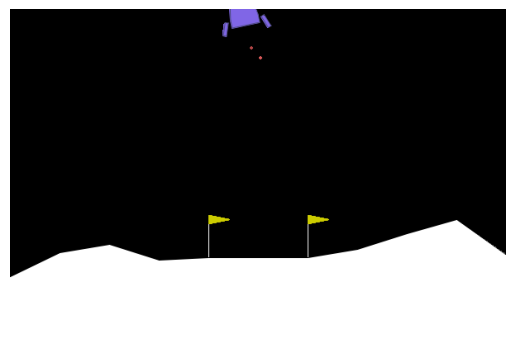

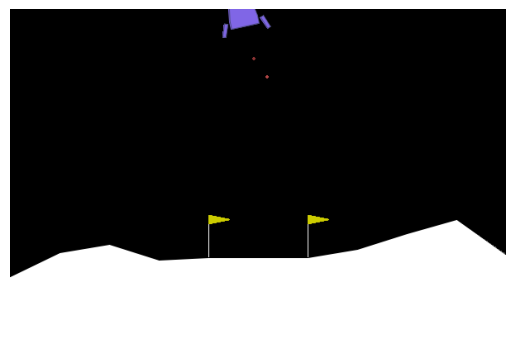

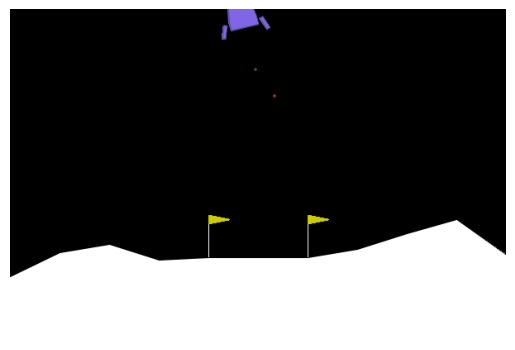

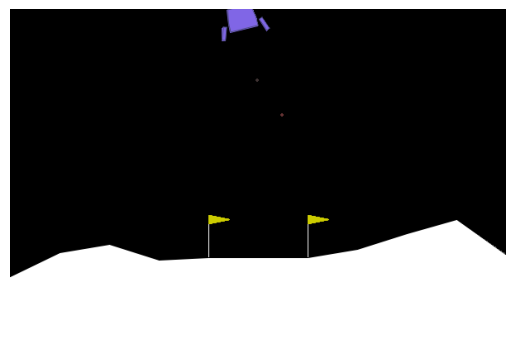

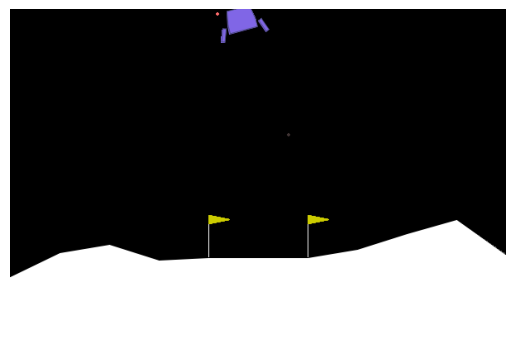

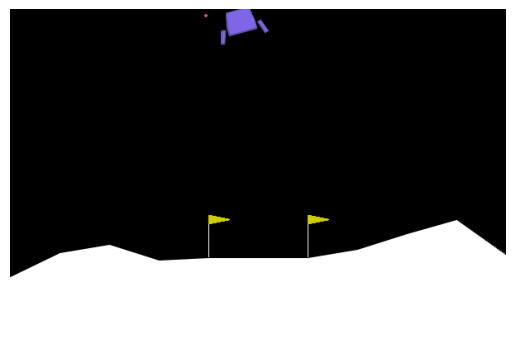

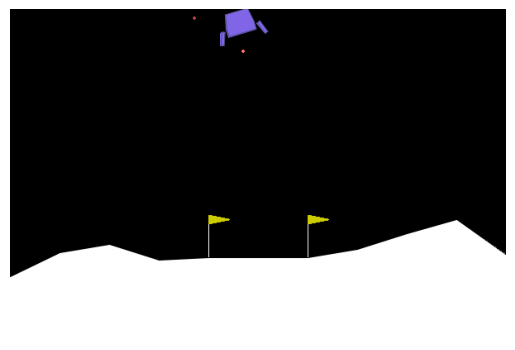

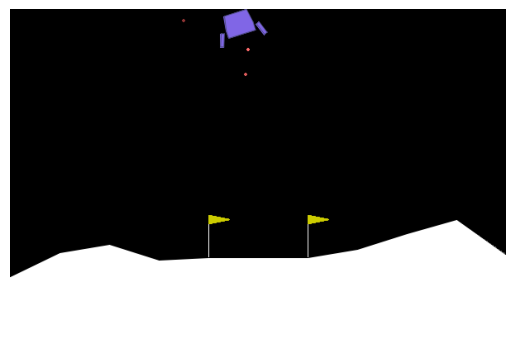

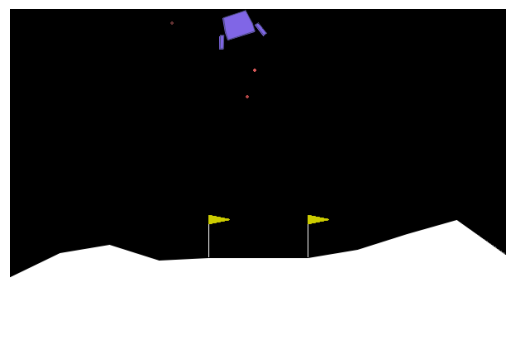

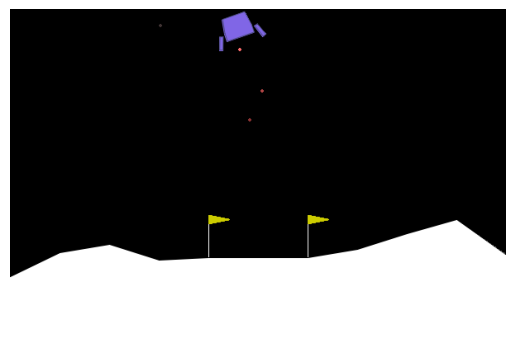

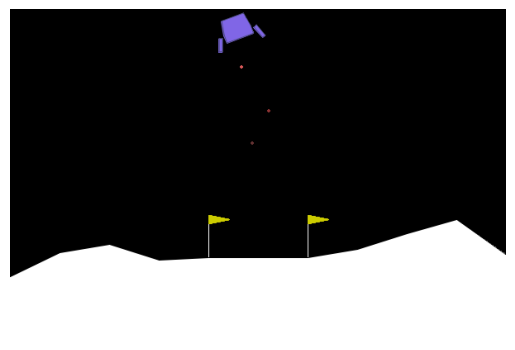

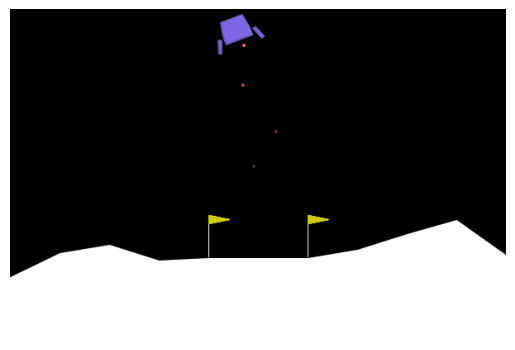

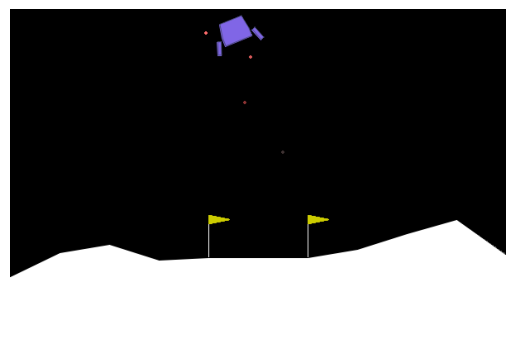

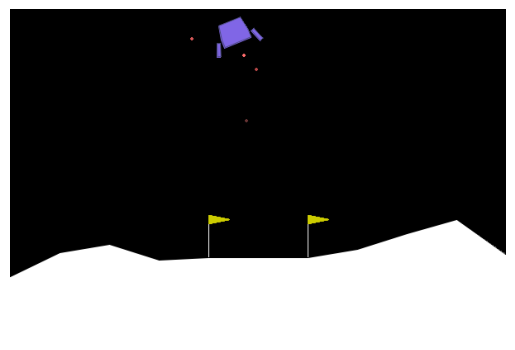

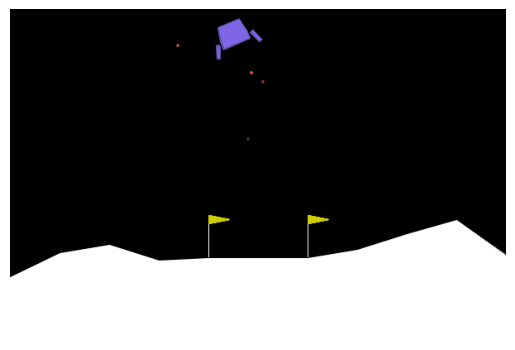

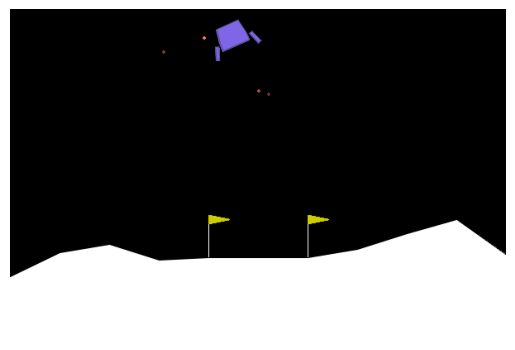

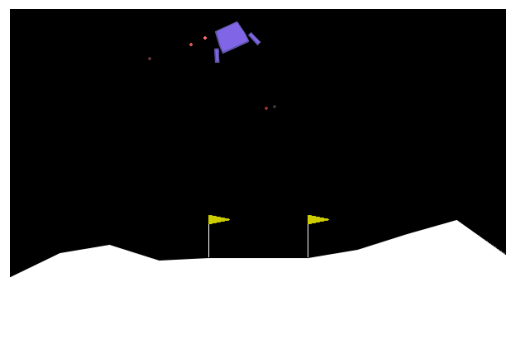

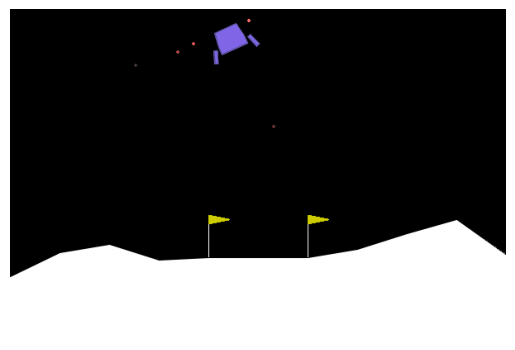

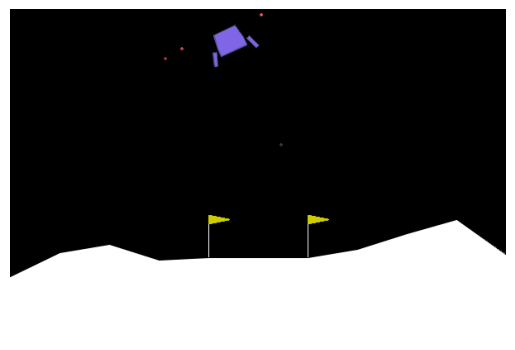

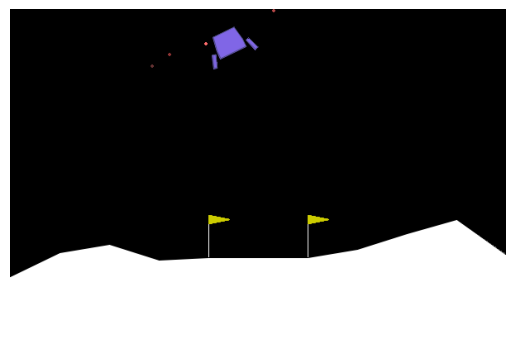

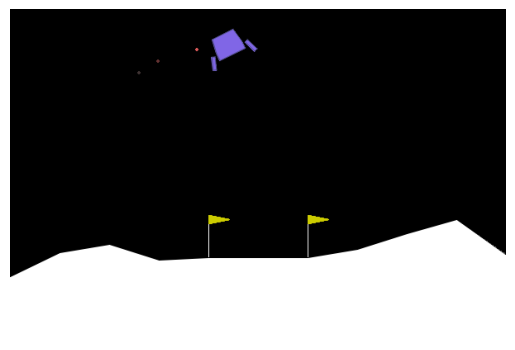

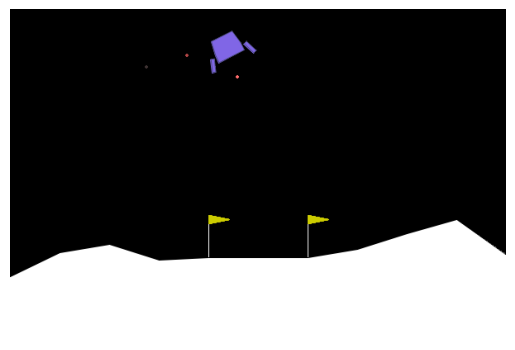

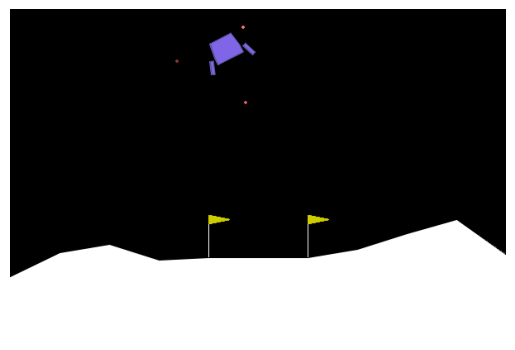

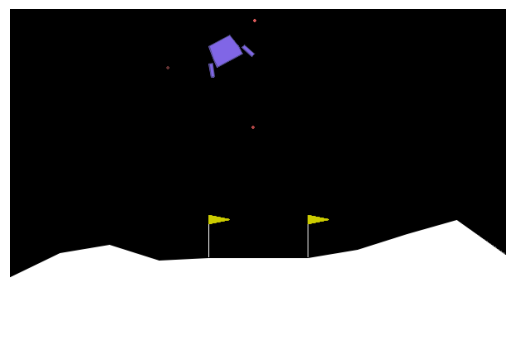

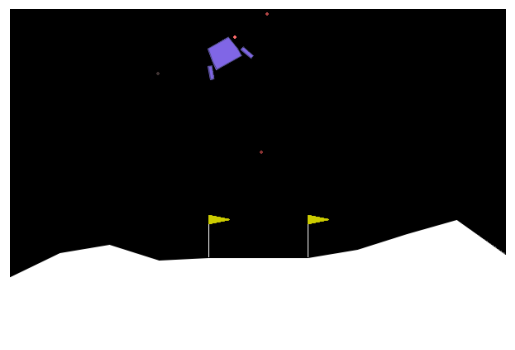

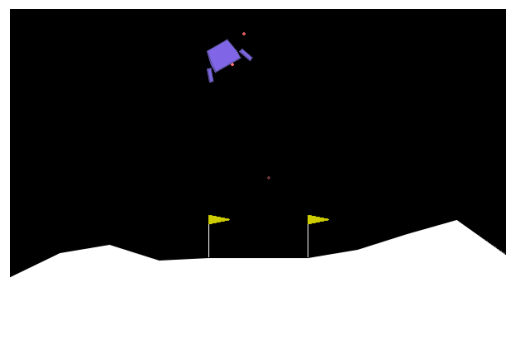

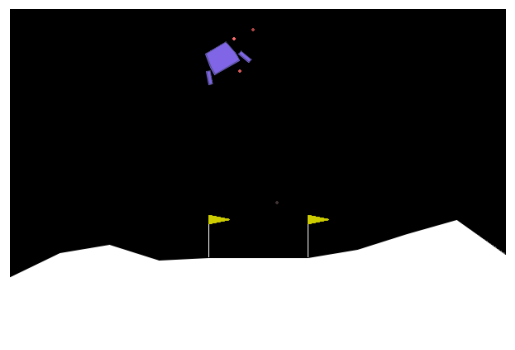

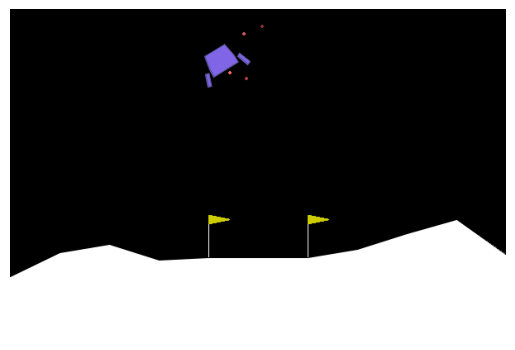

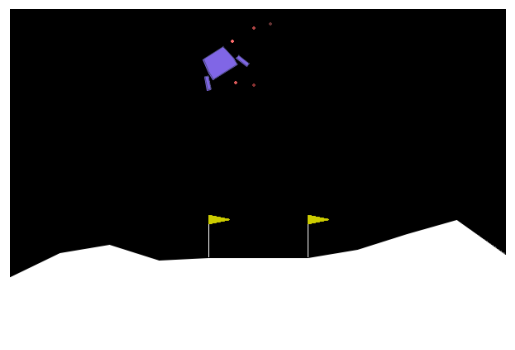

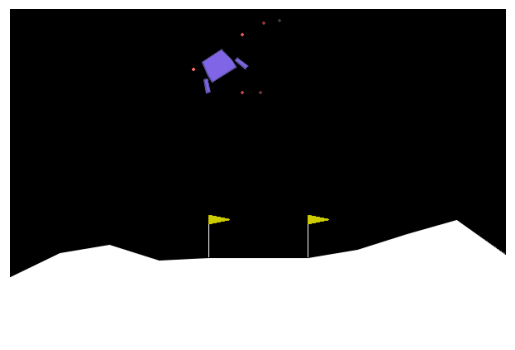

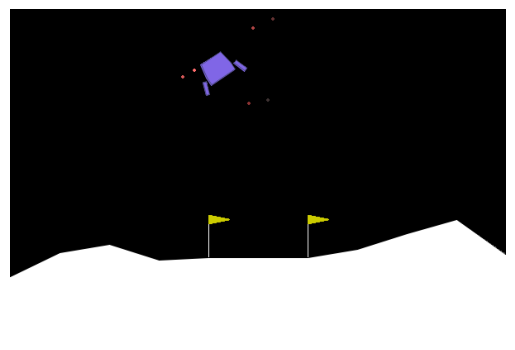

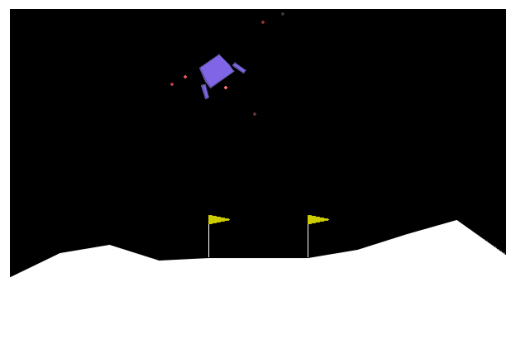

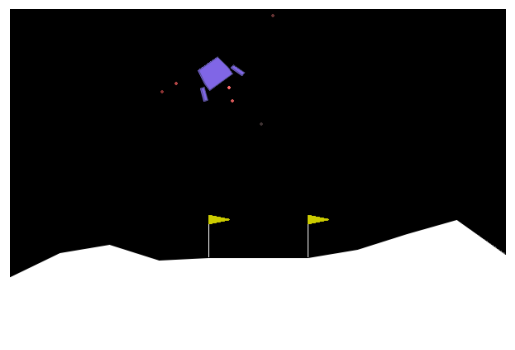

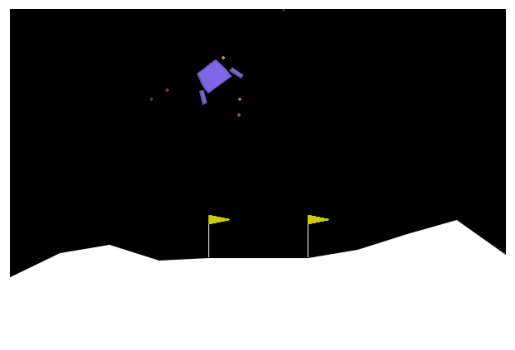

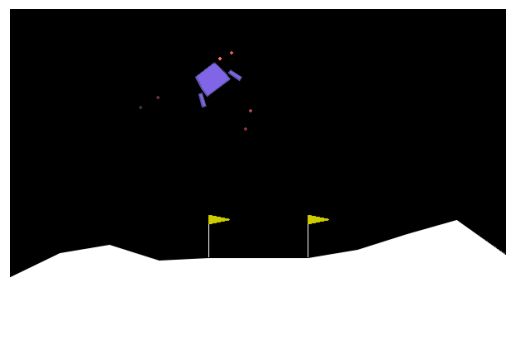

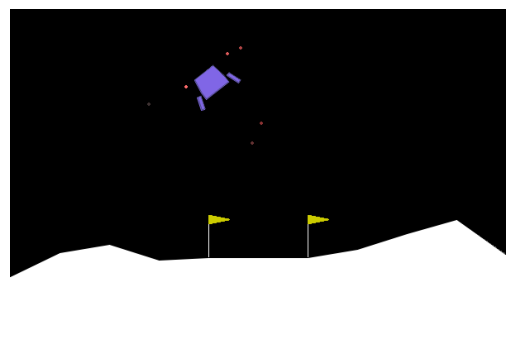

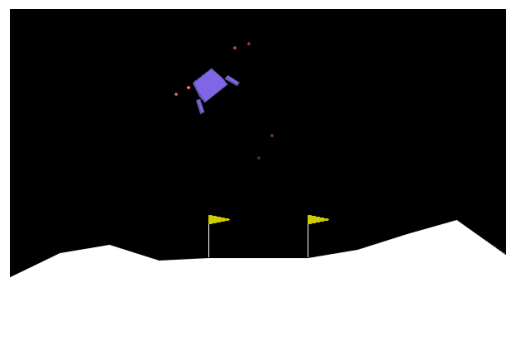

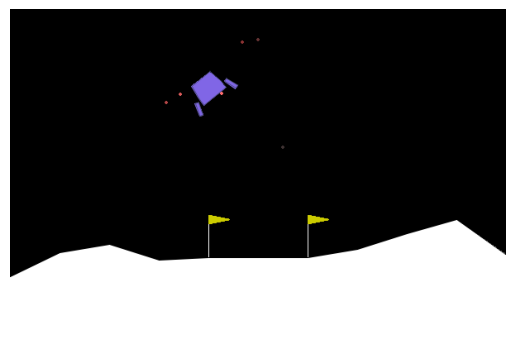

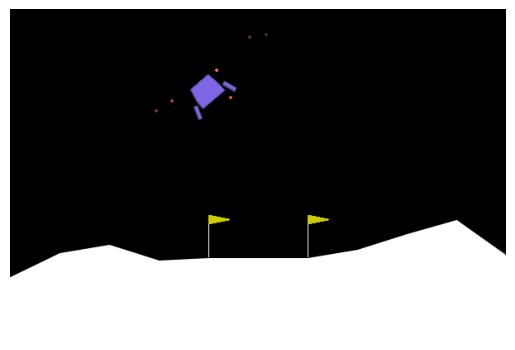

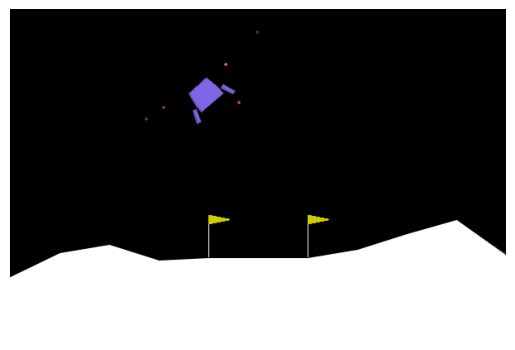

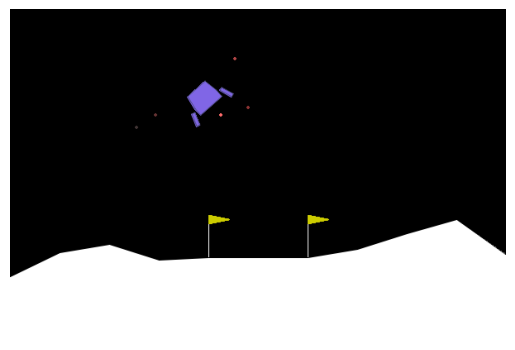

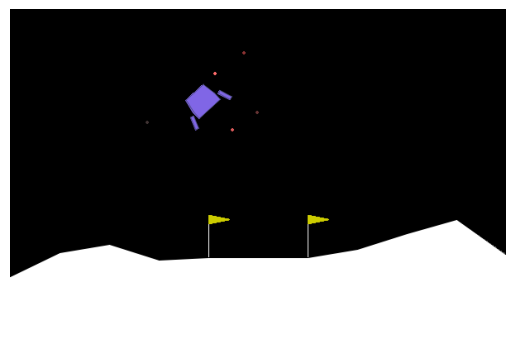

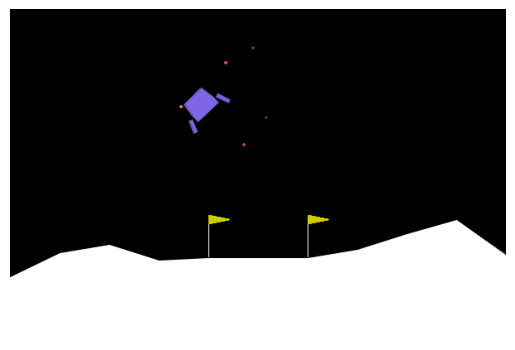

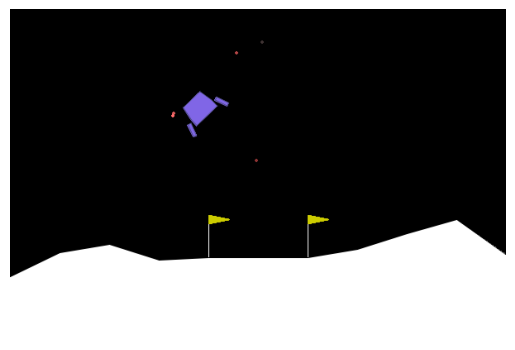

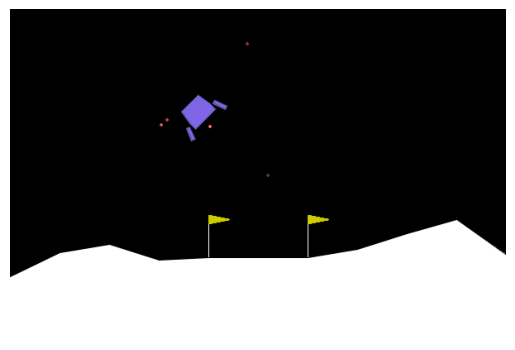

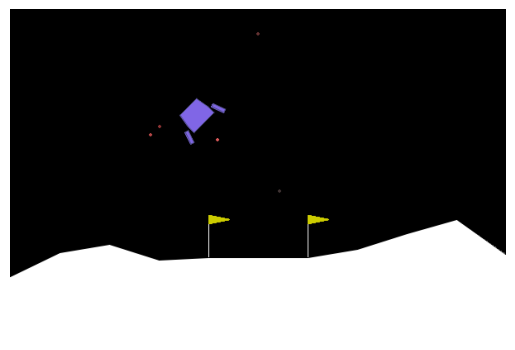

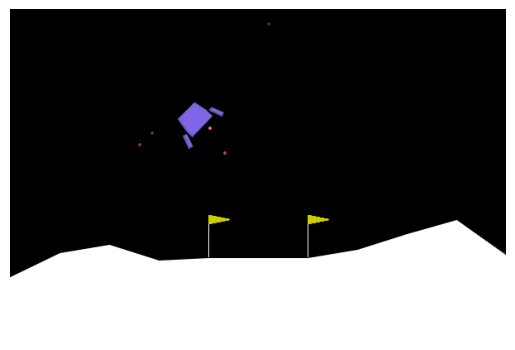

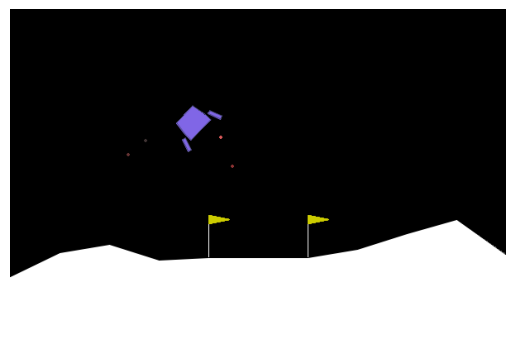

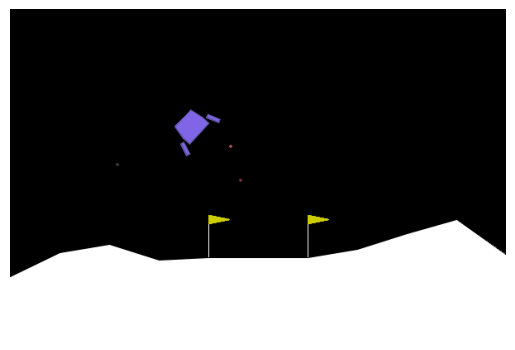

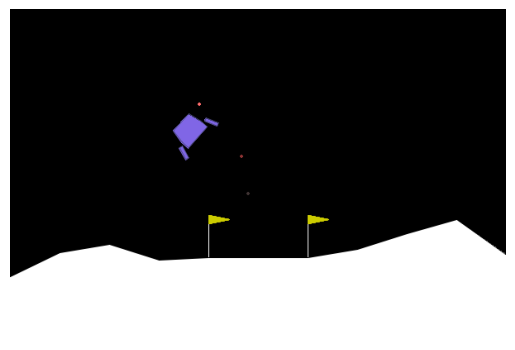

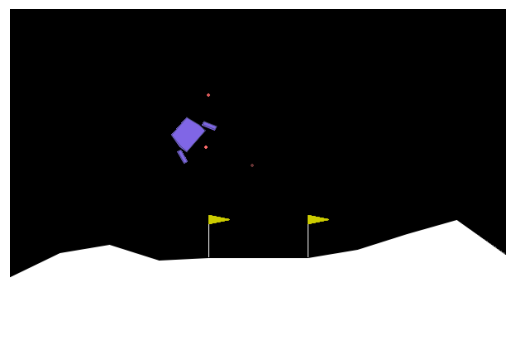

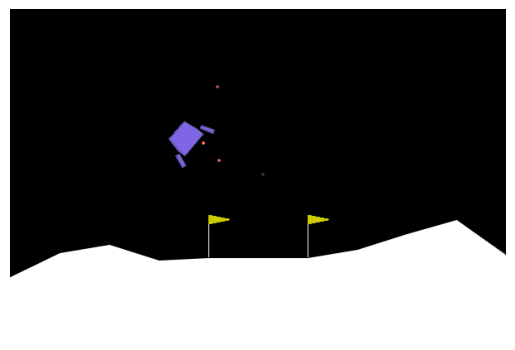

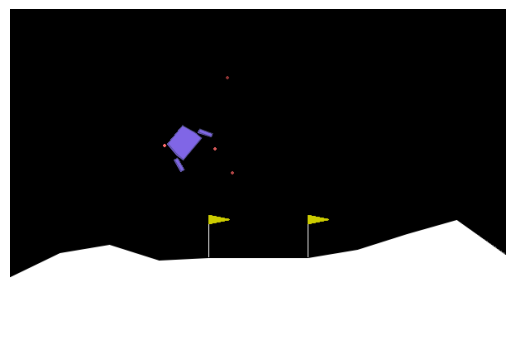

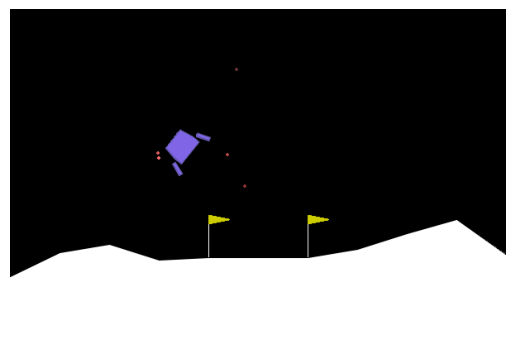

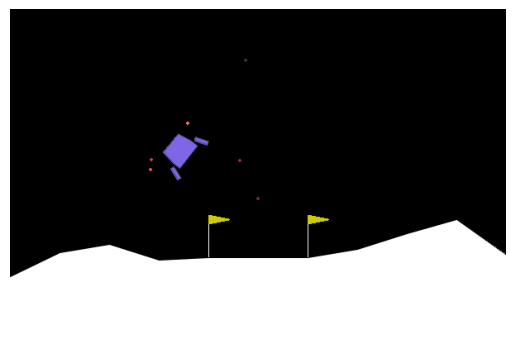

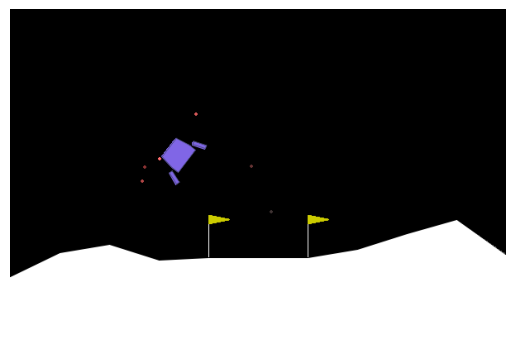

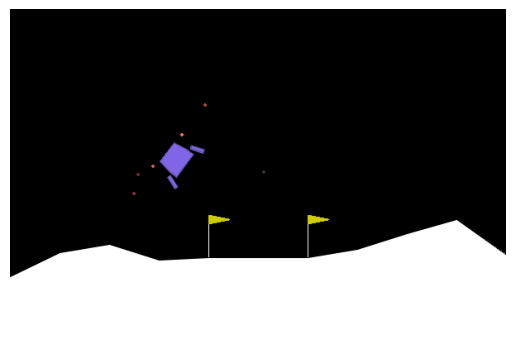

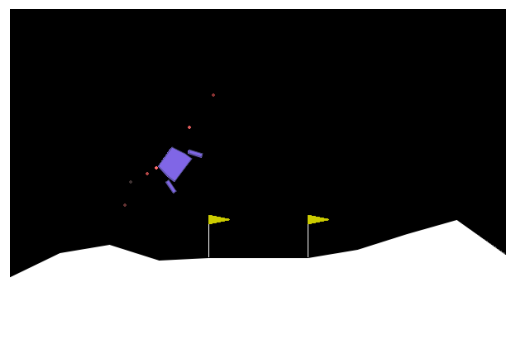

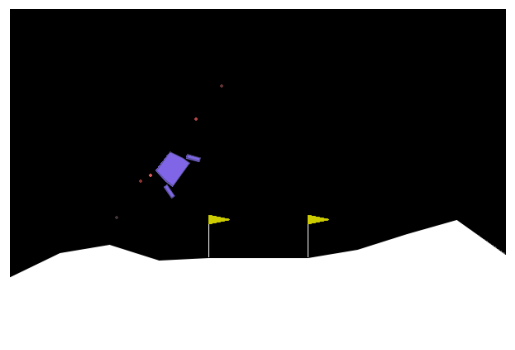

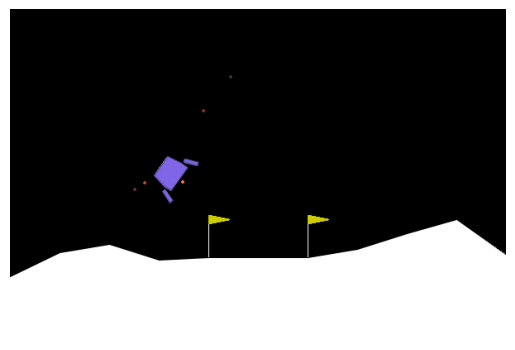

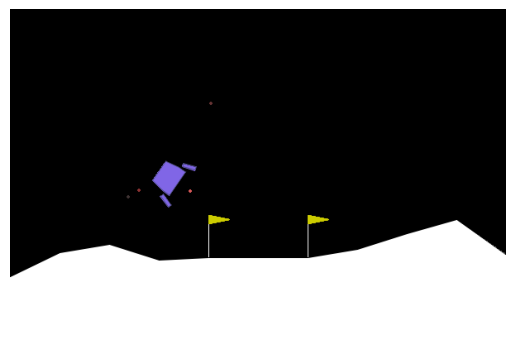

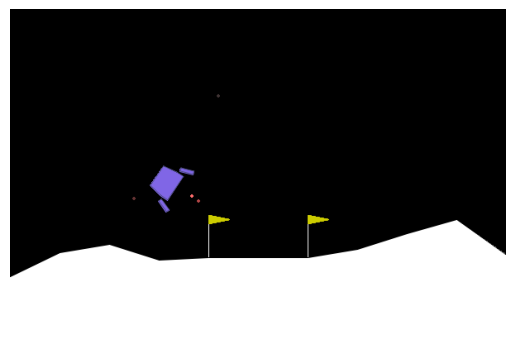

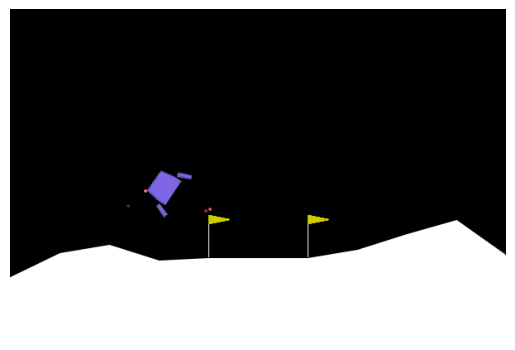

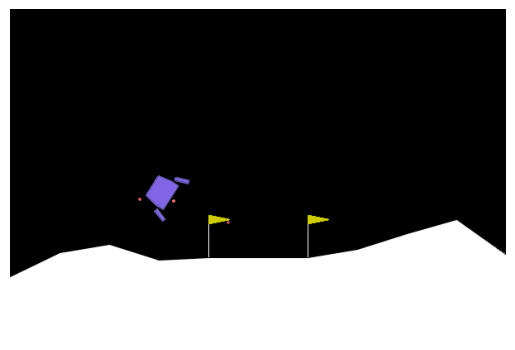

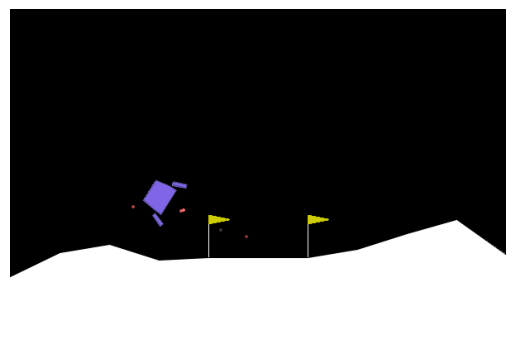

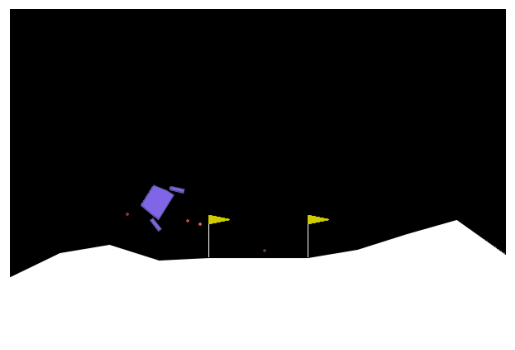

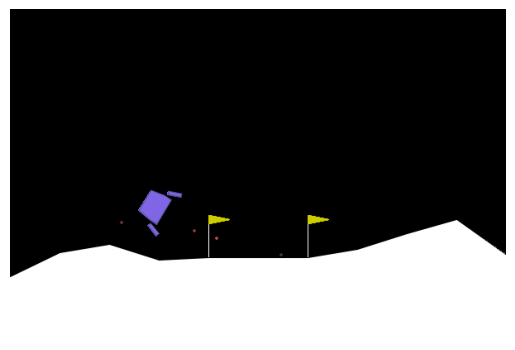

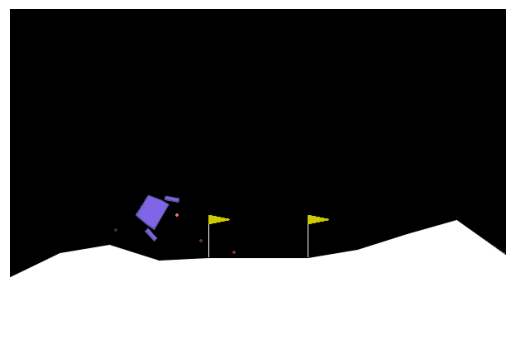

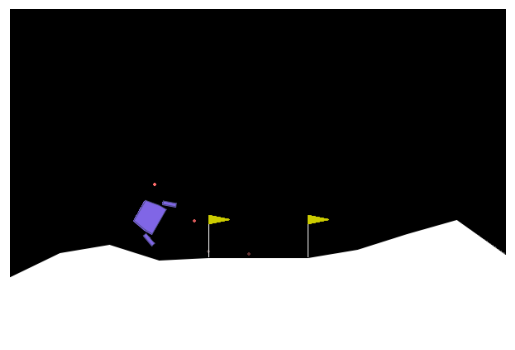

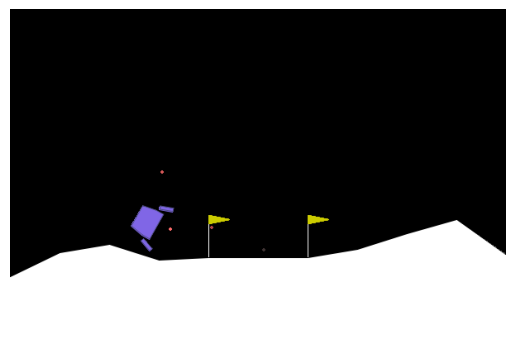

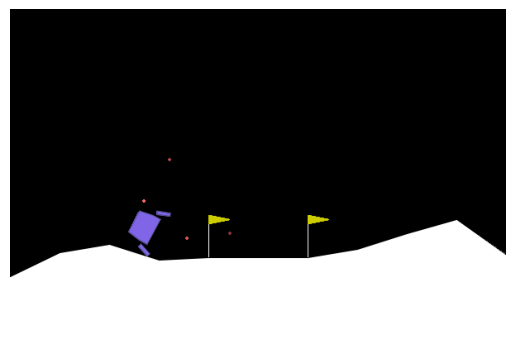

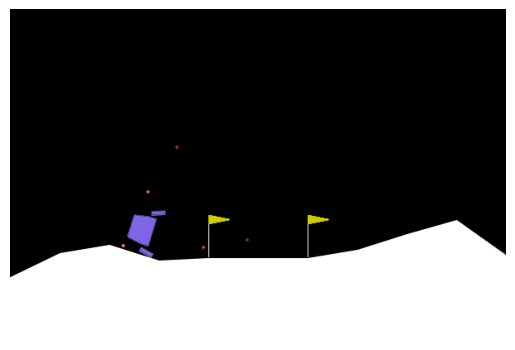

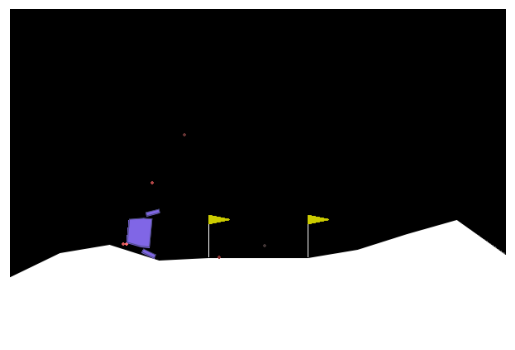

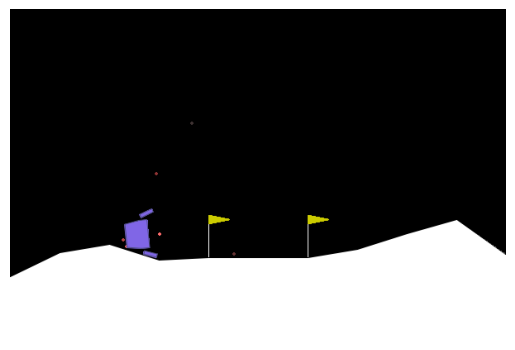

In [202]:
%matplotlib inline

# Create the LunarLander environment
env = gym.make('LunarLander-v2',render_mode="rgb_array")

# Reset the environment to its initial state
observation = env.reset()

# Run the environment until done
done = False
while not done:
    # Render the environment
    plt.imshow(env.render())
    plt.axis('off')
    plt.show()

    # Take a random action
    action = env.action_space.sample()

    # Perform the action in the environment
    observation, reward, done,_, info = env.step(action)

# Close the environment after rendering
env.close()